In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import datetime
from numba import jit

In [2]:
#!jupyter nbconvert --to script knn_project.ipynb

In [3]:

columns = ['1st', '2nd', '3rd', '4th', '5th', '6th', 'predict']

In [4]:
df = pd.read_csv('satisfaction_data.csv', names = columns)
df.head()

,1st,2nd,3rd,4th,5th,6th,predict
0,40,2,1,86872,25,9,unsatisfied
1,40,2,1,259323,54,10,satisfied
2,40,2,1,256813,43,14,satisfied
3,70,2,1,118793,51,13,satisfied
4,40,2,2,398918,28,9,unsatisfied


# check null value

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   1st      20000 non-null  int64 
 1   2nd      20000 non-null  int64 
 2   3rd      20000 non-null  int64 
 3   4th      20000 non-null  int64 
 4   5th      20000 non-null  int64 
 5   6th      20000 non-null  int64 
 6   predict  20000 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.1+ MB


In [6]:
df.describe()

,1st,2nd,3rd,4th,5th,6th
count,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000
mean,43.220150,2.358600,1.170800,1.847070e+05,39.434400,10.304350
std,11.842909,1.136825,0.564396,1.011263e+05,12.877026,2.454938
min,1.000000,0.000000,0.000000,1.376900e+04,17.000000,1.000000
25%,40.000000,2.000000,1.000000,1.148212e+05,30.000000,9.000000
50%,40.000000,2.000000,1.000000,1.759280e+05,38.000000,10.000000
75%,50.000000,2.000000,2.000000,2.318010e+05,48.000000,13.000000
max,99.000000,5.000000,2.000000,1.097453e+06,90.000000,16.000000


# numeric, category col 정리

<AxesSubplot:xlabel='6th', ylabel='Count'>

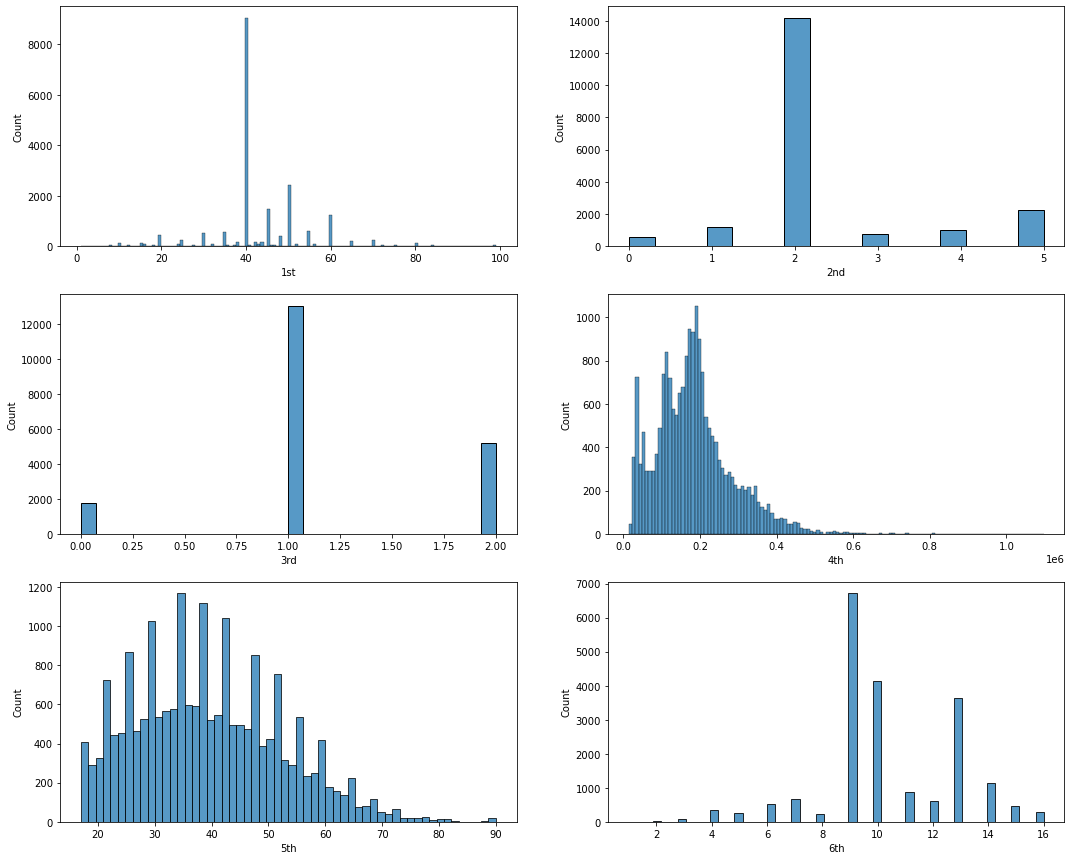

In [7]:

fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(18,15))
sns.histplot(df['1st'], ax=ax[0][0])
sns.histplot(df['2nd'], ax=ax[0][1])
sns.histplot(df['3rd'], ax=ax[1][0])
sns.histplot(df['4th'], ax=ax[1][1])
sns.histplot(df['5th'], ax=ax[2][0])
sns.histplot(df['6th'], ax=ax[2][1])


### 모든 칼럼의 분포를 확인했을때, 1st, 4th, 5th, 6th 열은 numeric col이고, 2nd,3rd 열은 category col임을 확인할 수 있다.

## data 분리

In [8]:
x = df.iloc[:, : -1]
y = df.iloc[:,6:]

In [9]:
# unsatisfied -> 0 / satisfied -> 1 변경
y = y.replace('unsatisfied',0).replace('satisfied',1)

In [10]:
x.head()

,1st,2nd,3rd,4th,5th,6th
0,40,2,1,86872,25,9
1,40,2,1,259323,54,10
2,40,2,1,256813,43,14
3,70,2,1,118793,51,13
4,40,2,2,398918,28,9


In [11]:
y.head()

,predict
0,0
1,1
2,1
3,1
4,0


## One Hot Encoding & Standard Scaler

In [12]:
def pipe_processing(x_train, x_test):
    numeric_features = ['1st', '4th', '5th', '6th']
    numeric_transformer = StandardScaler() 

    categorical_features = ['2nd', '3rd']
    categorical_transformer = OneHotEncoder()
    
    preprocessor = ColumnTransformer(
        transformers=[ 
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)]) 
    preprocessor_pipe.fit(x_train)
    x_train_transformed = preprocessor_pipe.transform(x_train)
    x_test_transformed = preprocessor_pipe.transform(x_test)
    
    return x_train_transformed, x_test_transformed

-------------------------------------------------------------------------------------

## knn을 위한 함수 정의

In [13]:
@jit(nopython=True)
def euclidean_distance(x1, train_data):
    distance_list = []
    for i in range(len(train_data)):
        dist = 0
        for j in range(len(x1)):
            dist += ((x1[j] - train_data[i][j]) ** 2)
        dist = dist ** 0.5
        distance_list.append((dist, i))
    distance_list.sort()
    return distance_list
    

In [14]:
# k개의 가장 가까운 점의 라벨 체크
def get_nearest_neighbor(distance_list, k, y_data):
    result = distance_list[:k]
    k_label = []
    for i in range(k):
        k_label.append(y_data[result[i][1]][0])

    return k_label

In [15]:
# list 내에서 최빈값을 label로 결정
def get_label(labels):
    return max(set(labels), key=labels.count)

In [16]:

def knn(test, train, k, y_train):
    predictions = []
    for i in range(len(test)):
        distance_list = euclidean_distance(test[i], train)
        k_labels = get_nearest_neighbor(distance_list, k, y_train)
        predictions.append(get_label(k_labels))
    return predictions

In [17]:
# 최적의 k값 찾는 함수
def elbow():
    x_train, x_test, y_train, y_test  = train_test_split(x,y,test_size=0.1,random_state=0)
    x_train_transformed , x_test_transformed= pipe_processing(x_train, x_test)
    y_train = np.array(y_train)
    
    error= []
    for i in range(1,30):
        y_predict = knn(x_test_transformed, x_train_transformed,i, y_train)
        error.append(1-(accuracy_score(y_test,y_predict)))
    return error

In [ ]:
errors = elbow()

In [ ]:
plt.plot(range(1,30),errors,'r-',marker='o')
plt.xlabel('K')
plt.ylabel('Error')
plt.title('Error vs K value')

In [ ]:

def kfold(x,y):
    accuracy_history = []
    test_size = 0.1
    random_state = 0
    num_folds= 10 # test_size = 0.1
    kfold = KFold(n_splits = num_folds, shuffle = True, random_state = random_state)
    count = 1
    columns = ['1st', '2nd', '3rd', '4th', '5th', '6th']
    best_score = -1
    for train_index, test_index in kfold.split(x, y):
            X_train, X_test = np.array(x)[train_index], np.array(x)[test_index]
            y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
            X_train = pd.DataFrame(X_train, columns = columns)
            X_test = pd.DataFrame(X_test, columns = columns)
            
            y_train_df = pd.DataFrame(y_train, columns=['predict'])
            y_test_df = pd.DataFrame(y_test, columns=['predict'])
            train_df = pd.concat([X_train, y_train_df], axis=1)
            test_df = pd.concat([X_test, y_test_df], axis=1)
            
            train_df.to_csv("train_set" + str(count) + ".csv")
            test_df.to_csv("test_set" + str(count) + ".csv")
            
            
            x_train_transformed , x_test_transformed= pipe_processing(X_train, X_test)
            y_predict = knn(x_test_transformed, x_train_transformed,17, y_train)
            score = accuracy_score(y_test,y_predict)
            
            if score > best_score:
                best_score = score
                best_predict = y_predict
                best_test_df = test_df

            accuracy_history.append(score)
            count += 1
    return best_test_df, best_predict, accuracy_history


In [ ]:

start = datetime.datetime.now()
best_test_df, y_result, accuracy_history = kfold(x,y)
end = datetime.datetime.now()
print("모델 실행시간:", end-start)
print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 정확도 :", np.mean(accuracy_history)) 

In [ ]:
def get_user_predict_file(best_test_df, y_result):
    predict_data = pd.concat([best_test_df, pd.DataFrame(y_result)], axis=1)
    predict_data.rename(columns={'predict':'Satisfaction', 0:'predict'}, inplace = True)
    predict_data.to_csv("20171006.csv")
    

In [ ]:
get_user_predict_file(best_test_df, y_result)